In [1]:
import keras
from keras import layers
import tensorflow as tf
import pydot
from tensorflow.python.keras.models import load_model


from loadTDMS import *
from fft_test import *

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from tqdm import tqdm

### Select caseNum, trainTool

In [2]:
caseNum = 7
trainTool = "A"

In [3]:
info = pd.read_csv(rf"Z:\200 Produced_data\MashineLearning\case_info.csv")

In [4]:
# info[info['caseNum'] == caseNum and info['trainTool'] == trainTool]
info = info[info['caseNum'] == caseNum]
info = info[info['trainTool'] == trainTool]
info

,Unnamed: 0,caseNum,trainTool,AE_location,fq,fq_num,path_start,path_end
10,0,7,A,spindle,[4 5 6],3,41,60
11,0,7,A,spindle,[4 5 6],3,41,60


### Get fq_num, path_start, path_end, interval

In [5]:
info['fq_num']
fq_num = info['fq_num'].values[0]
fq_num = fq_num*82
print(f"fq_num: {fq_num}")

path_start = info['path_start'].values[0]
print(f"path_start: {path_start}")

path_end = info['path_end'].values[0]
print(f"path_end: {path_end}")

total_path = path_end - path_start + 1
print(f"total_path: {total_path}")

if trainTool =="A":
    interval = 1200
if trainTool =="B":
    interval = 1200
if trainTool =="C":
    interval = 1023

print(f"interval: {interval}")

fq_num: 246
path_start: 41
path_end: 60
total_path: 20
interval: 1200


### Load TrainD

In [6]:
# Load Train D
train_d = np.load(rf"Z:\200 Produced_data\MashineLearning\trainD\case{caseNum}_{trainTool}.npy")

In [7]:
# print Train data's set number
len(train_d)/fq_num

24000.0

### Load TestD

In [8]:
test_A = np.load(rf"Z:\200 Produced_data\MashineLearning\testD\case{caseNum}_{trainTool}_A.npy")
test_B = np.load(rf"Z:\200 Produced_data\MashineLearning\testD\case{caseNum}_{trainTool}_B.npy")
test_C = np.load(rf"Z:\200 Produced_data\MashineLearning\testD\case{caseNum}_{trainTool}_C.npy")

In [9]:
print(len(test_A)/fq_num) #552000 sets
print(len(test_B)/fq_num) #552000 sets
print(len(test_C)/fq_num) #470580 sets

552000.0
552000.0
470580.0


### reshape for train and test

In [10]:
# reshape for train and test
# 164 = fft 200-300kHzのampの返り値の数（0-500kHz:820個) 
train_d = train_d.reshape(int(len(train_d)/fq_num),fq_num)
test_A = test_A.reshape(int(len(test_A)/fq_num),fq_num)
test_B = test_B.reshape(int(len(test_B)/fq_num),fq_num)
test_C = test_C.reshape(int(len(test_C)/fq_num),fq_num)

In [11]:
print(train_d.shape)
print(test_A.shape)
print(test_B.shape)
print(test_C.shape)

(24000, 246)
(552000, 246)
(552000, 246)
(470580, 246)


In [12]:
train_d.shape[1]

246

### Define Model

In [13]:
#モデルの定義
model =keras.initializers.Initializer()
model = keras.Sequential(
    [
        layers.Input(shape=(train_d.shape[1],1)),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 246, 32)           256       
                                                                 
 dropout (Dropout)           (None, 246, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 246, 16)           3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 246, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 246, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 246, 32)          3616      
 ranspose)                                              

### Train Model

In [14]:
%%time
history = model.fit(
    train_d,
    train_d,
    epochs=60,
    batch_size=100,
    validation_split=0.1,
#     callbacks=[
#         keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
#     ],
)

Epoch 1/60
216/216 [==============================] - 19s 84ms/step - loss: 0.1031 - val_loss: 0.0061
Epoch 2/60
216/216 [==============================] - 18s 83ms/step - loss: 0.0255 - val_loss: 0.0054
Epoch 3/60
216/216 [==============================] - 19s 87ms/step - loss: 0.0208 - val_loss: 0.0083
Epoch 4/60
216/216 [==============================] - 18s 84ms/step - loss: 0.0181 - val_loss: 0.0112
Epoch 5/60
216/216 [==============================] - 18s 85ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 6/60
216/216 [==============================] - 19s 88ms/step - loss: 0.0140 - val_loss: 0.0214
Epoch 7/60
216/216 [==============================] - 19s 87ms/step - loss: 0.0126 - val_loss: 0.0228
Epoch 8/60
216/216 [==============================] - 19s 88ms/step - loss: 0.0113 - val_loss: 0.0291
Epoch 9/60
216/216 [==============================] - 19s 87ms/step - loss: 0.0103 - val_loss: 0.0315
Epoch 10/60
216/216 [==============================] - 19s 88ms/step - loss: 0.009

### Save model weight

In [15]:
# model.save(rf"Z:\200 Produced_data\MashineLearning\Weight\case{caseNum}_{trainTool}.h5")
model.save(rf"Z:\200 Produced_data\MashineLearning\Weight\case{caseNum}_{trainTool}_NC.h5")

### Show the Training data Loss and Validation data Loss

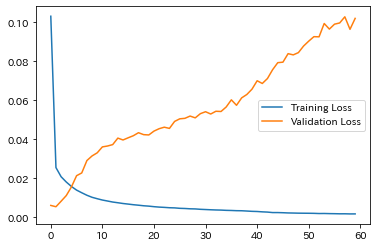

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

### Predict with TrainData and Get threshold(μ+3σ)

In [17]:
#predict(train data)
train_d_pred = model.predict(train_d)
print(train_d_pred.shape)

# ex) if trainTool is A or B reshape(1200×total_path, fq_num, 1) -> (1200×total_path, fq_num)
#     if trainTool is C reshape(1023×total_path, fq_num, 1) -> (1023×total_path, fq_num)
train_d_pred = train_d_pred.reshape(interval*total_path, fq_num)

#再構成誤差計算
train_mae_loss = np.mean(np.square(np.abs(train_d_pred - train_d)), axis=1)

#再構成誤差の平均値
train_mae_loss_mean = np.mean(train_mae_loss)

#再構成誤差の標準偏差
train_mae_loss_std = np.std(train_mae_loss)

#閾値設定
#閾値T = μ+3σ (μ:train_dの再構成誤差の平均値、σ:train_d（A（51~60path）200-300kHz）の再構成誤差のの標準偏差)

threshold = train_mae_loss_mean + train_mae_loss_std * 3

750/750 [==============================] - 7s 9ms/step
(24000, 246, 1)


In [18]:
print(train_mae_loss_mean)
print(train_mae_loss_std)
print(threshold)

0.17574789487056386
0.1907790341782126
0.7480849974052016


### Predict with TestData and Get Reconstruction Error of TestData

In [19]:
%%time
# 5-10分かかる
# test(A,B,C 1-460pah) predict & reshape & get reconstruction error
test_A_pred = model.predict(test_A)
test_A_pred = test_A_pred.reshape(552000,fq_num)

test_B_pred = model.predict(test_B)
test_B_pred = test_B_pred.reshape(552000,fq_num)

test_C_pred = model.predict(test_C)
test_C_pred = test_C_pred.reshape(470580,fq_num)


test_A_mae_loss = np.mean(np.square(np.abs(test_A_pred - test_A)), axis=1)
test_B_mae_loss = np.mean(np.square(np.abs(test_B_pred - test_B)), axis=1)
test_C_mae_loss = np.mean(np.square(np.abs(test_C_pred - test_C)), axis=1)

14706/14706 [==============================] - 131s 9ms/step
Wall time: 9min 6s


In [20]:
#RE は　Reconstruction Errorの略
test_A_RE = test_A_mae_loss.reshape(-1)
test_B_RE = test_B_mae_loss.reshape(-1)
test_C_RE = test_C_mae_loss.reshape(-1)

print(test_A_RE.shape)
print(test_B_RE.shape)
print(test_C_RE.shape)

# save RE
# np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_A", test_A_RE)
# np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_B", test_B_RE)
# np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_C", test_C_RE)

np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_A_NC", test_A_RE)
np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_B_NC", test_B_RE)
np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_C_NC", test_C_RE)

(552000,)
(552000,)
(470580,)


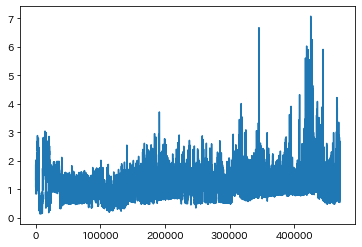

In [23]:
# plt.plot(test_A_RE)
# plt.plot(test_B_RE)
plt.plot(test_C_RE)

### some calc for matching the size

In [24]:
# test_A_RE = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_A.npy")
# test_B_RE = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_B.npy")
# test_C_RE = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_C.npy")


test_A_RE = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_A_NC.npy")
test_B_RE = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_B_NC.npy")
test_C_RE = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_C_NC.npy")


print(len(test_A_RE)/1200)
print(len(test_B_RE)/1200)
print(len(test_C_RE)/1023)

460.0
460.0
460.0


In [25]:
#all_path_num
a_p_n = 460
#all_rotation_num
a_r_n = 1200
a_r_n_2 = 1023
#moving avg path step
m_a_p_s = 10

w_size = a_r_n*m_a_p_s
w_size2 = a_r_n_2*m_a_p_s

x = np.linspace(-1,1,w_size)
x2 = np.linspace(-1,1,w_size2)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v2 = np.exp(-x2**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v2 = v2 / np.sum(v2)
v = np.sort(v)[::-1]
v2 = np.sort(v2)[::-1]

In [26]:
%%time
#1-2分かかる
RE_MA_A = np.convolve(test_A_RE,v, mode='valid')
RE_MA_B = np.convolve(test_B_RE,v, mode='valid')
RE_MA_C = np.convolve(test_C_RE,v2, mode='valid')

Wall time: 1min 12s


In [27]:
# np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_A_MA", RE_MA_A)
# np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_B_MA", RE_MA_B)
# np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_C_MA", RE_MA_C)


np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_A_MA_NC", RE_MA_A)
np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_B_MA_NC", RE_MA_B)
np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_C_MA_NC", RE_MA_C)

In [28]:
tools = ["A", "B", "C"]
intervals = [1200, 1200, 1023]

In [29]:
for tool, interval in zip(tools, intervals):
#     RE_MA = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_{tool}_MA.npy")
    RE_MA = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_{tool}_MA_NC.npy")    
    new = RE_MA[:-1]
    print(len(new)/interval)
    new = new.reshape(interval*10, int(len(new)/(interval*10)))
    print(new.shape)
    avg = np.average(new,axis=1)
    print(avg.shape)
    avg = avg.reshape(len(avg),1)
    print(avg.shape)
    avg = np.repeat(avg, 1, axis=1)
    print(avg.shape)
    new_n = np.block([new,avg])
    new_n = new_n.ravel()
    print(len(new_n)/interval)
    
    if tool == "C":
        new_nn = new_n.reshape(int(len(new_n)/interval), interval)
        print(new_nn.shape)
        hokan = 1200-1023
        avg = np.average(new_nn, axis=1)
        avg = avg.reshape(len(avg), 1)
        avg = np.repeat(avg, hokan, axis=1)
        new_nn  = np.block([new_nn, avg])
        print(new_nn.shape)
        new_nn = new_nn.ravel()
        print(len(new_nn)/1200)
#         np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_{tool}_MA_EX.npy",new_nn)
        np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_{tool}_MA_EX_NC.npy",new_nn)

    else:
#         np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_{tool}_MA_EX.npy",new_n)
        np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_{tool}_MA_EX_NC.npy",new_n)

    print("-----------------")

450.0
(12000, 45)
(12000,)
(12000, 1)
(12000, 1)
460.0
-----------------
450.0
(12000, 45)
(12000,)
(12000, 1)
(12000, 1)
460.0
-----------------
450.0
(10230, 45)
(10230,)
(10230, 1)
(10230, 1)
460.0
(460, 1023)
(460, 1200)
460.0
-----------------


In [30]:
# A = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_A_MA_EX.npy")
# B = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_B_MA_EX.npy")
# C = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_C_MA_EX.npy")

A = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_A_MA_EX_NC.npy")
B = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_B_MA_EX_NC.npy")
C = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case{caseNum}_{trainTool}_C_MA_EX_NC.npy")




# A_ = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\hinan\case{caseNum}_{trainTool}_A_MA_EX.npy")
# B_ = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\hinan\case{caseNum}_{trainTool}_B_MA_EX.npy")
# C_ = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\hinan\case{caseNum}_{trainTool}_C_MA_EX.npy")

In [28]:
print(caseNum)
print(trainTool)

1
B


In [31]:
%matplotlib qt
plt.plot(A)
# plt.plot(A_)

In [32]:
%matplotlib qt
plt.plot(B)
# plt.plot(B_)

In [33]:
%matplotlib qt
plt.plot(C)
# plt.plot(C_)

In [34]:
%matplotlib qt
plt.plot(A)
plt.plot(B)
plt.plot(C)

In [62]:
# %matplotlib qt
# plt.plot(A_)
# plt.plot(B_)
# plt.plot(C_)

NameError: name 'B_' is not defined

In [37]:
%matplotlib qt
#all_path_num
a_p_n = 120
#all_rotation_num
a_r_n = 1200
#moving avg path step
m_a_p_s = 30


fig = plt.figure()
ax = fig.add_subplot()
ax.set_xticks(np.arange(0, a_p_n*a_r_n + 1, a_r_n*m_a_p_s))
ax.set_xticklabels(np.arange(0,a_p_n + 1,m_a_p_s))
ax.set_xlabel(xlabel='Path Number')
# ax.set_ylabel(ylabel='Cutting Force[N]')
ax.tick_params(axis = 'x')
ax.tick_params(axis = 'y')

ax = ax.twinx()
ax.set_ylabel(ylabel='Reconstruction Error')


# ax.plot(cfm_C, label="Cutting Force", linewidth="5")
# ax.plot(A_, label="Reconstruction Error", color="magenta")
# ax.plot(A[:a_p_n*a_r_n])
# ax.plot(B[:a_p_n*a_r_n])
ax.plot(C[:a_p_n*a_r_n])